In [7]:
# Auto reload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
import yaml
import datetime
import argparse
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# set tf to cpu only
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")
import jax
jax.config.update("jax_platform_name", "cpu")

import sys
sys.path.append("/robin-west/VBD")

from vbd.data.dataset import WaymaxDataset
from vbd.model.VBD import VBD
from torch.utils.data import DataLoader

import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger, CSVLogger
from lightning.pytorch.strategies import DDPStrategy

from matplotlib import pyplot as plt

In [9]:
def load_config(file_path):
    with open(file_path, "r") as file:
        data = yaml.safe_load(file)
    return data

In [10]:
config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_15_no_cond_attn_ego_validate.yaml"
# config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_0_cond_attn_ego_validate.yaml"
# config_path = "/robin-west/VBD/config/_table_2/vbd_ego_agent_future_len_40_input_action_normalize_true_prior_means_steer_and_speed_scale_0_no_cond_attn_ego_classifier_validate_100.yaml"
cfg = load_config(config_path)
cfg['num_workers'] = 1
cfg['batch_size'] = 1
dataset_dir = '/root/single_agent_subset/validation/processed'

In [11]:
pl.seed_everything(cfg["seed"])
torch.set_float32_matmul_precision("high")    
    
# create dataset
from vbd.data.dataset import WaymaxTestDataset

val_dataset = WaymaxTestDataset(
    data_dir=dataset_dir,
    future_len = cfg["future_len"],
    anchor_path=cfg["anchor_path"],
    predict_ego_only=cfg["predict_ego_only"],
    action_labels_path=cfg["validation_action_labels_path"],
    max_object= cfg["agents_len"],
)

Seed set to 42


In [12]:
from copy import deepcopy
import random

from vbd.waymax_visualization.plotting import plot_ego, plot_state
import mediapy

In [13]:
import jax
import matplotlib.pyplot as plt
import numpy as np
def plot_batch_x_t_with_all_labels(scenario,agents_interested,x_t_history, timestep, batch, run_ids=None):
    assert timestep < len(x_t_history)
    steer_label_name = {
        0: 'go straight',
        1: 'left turn',
        2: 'right turn',
        3: 'U-turn',
    }
    speed_label_name = {
        1: 'accelerate',
        2: 'decelerate',
        3: 'keep speed'
    }
    x_ts = x_t_history[timestep]
    if run_ids is None:
        run_ids = np.arange(x_ts.shape[0])
    for i in run_ids:
        steer_label = batch[i]['sdc_steer_label']
        speed_label = batch[i]['sdc_speed_label'] # + 1 # reminder: remove this +1 for model after 0224
        print('id_{}_steer_{}_speed_{}'.format(i, steer_label_name[steer_label], speed_label_name[speed_label]))
        traj = x_ts[i]
        img = plot_ego(
            scenario, 
            ego_traj = traj[agents_interested[i]>0].detach().cpu().numpy(), 
            log_traj=True
            )
        # torch.norm(denoiser_outputs['denoised_trajs'][agents_interested>0][:, -1, 2:4])
        mediapy.show_image(img, width=400)

def plot_batch_all_x_t(scenario,agents_interested, x_ts, timestep, batch, run_ids=None):
    steer_label_name = {
        0: 'go straight',
        1: 'left turn',
        2: 'right turn',
        3: 'U-turn',
    }
    speed_label_name = {
        1: 'accelerate',
        2: 'decelerate',
        3: 'keep speed'
    }
    print(agents_interested)
    
    img = plot_ego(
        scenario, 
        traj_pred=x_ts, 
        log_traj=True
        )
    # torch.norm(denoiser_outputs['denoised_trajs'][agents_interested>0][:, -1, 2:4])
    mediapy.show_image(img, width=400)


def plot_batch_all_x_with_style(scenario,agents_interested, x_ts, style_dict, control_list, plot_freq, dx):
    steer_label_name = {
        0: 'go straight',
        1: 'left turn',
        2: 'right turn',
        3: 'U-turn',
    }
    speed_label_name = {
        1: 'accelerate',
        2: 'decelerate',
        3: 'keep speed'
    }
    print(agents_interested)
    
    img = plot_ego(
        scenario, 
        traj_pred=x_ts, 
        log_traj=True,
        style_dict=style_dict,
        control_list=control_list,
        plot_freq = plot_freq,
        dx = dx,
        )
    # torch.norm(denoiser_outputs['denoised_trajs'][agents_interested>0][:, -1, 2:4])
    mediapy.show_image(img, width=800)

In [14]:
def sample_with_random_id(val_dataset, i, speed_label, steer_label, size=16):
    if type(i) is int:
        scenario_id, scenario, data_dict = val_dataset.get_scenario_by_index(i)
    elif type(i) is str:
        scenario_id, scenario, data_dict = val_dataset.get_scenario_by_id(i)
    scenario.object_metadata.is_controlled = scenario.object_metadata.is_sdc
    # print(data_dict['sdc_speed_label'], data_dict['sdc_steer_label'])

    print(scenario_id)

    data_dict_ = deepcopy(data_dict)
    data_dict_['sdc_steer_label'] = steer_label
    data_dict_['sdc_speed_label'] = speed_label

    batch = [data_dict_] * size
    batch_collated = val_dataset.__collate_fn__(batch)

    model = VBD(cfg=cfg)
    ckpt_path = cfg.get("init_from", None)
    print("Load Weights from ", ckpt_path)
    model.load_state_dict(torch.load(ckpt_path, map_location=torch.device("cuda"))["state_dict"])

    device = torch.device("cuda:1")
    model.to(device)
    log_dict, denoiser_outputs, agents_interested, x_t_history = model.sample_denoiser_for_plot(batch_collated, calc_loss=True)   # log_dict compute the mean over all labels
    print(log_dict)
    return scenario, agents_interested, x_t_history, batch


def get_all(control_list, val_dataset, sid, size):
    results = []
    for control in control_list:
        speed = control[0]
        steer = control[1]
        scenario, agents_interested, x_t_history, batch = sample_with_random_id(val_dataset, sid, speed, steer, size=size)
        x_ts = x_t_history[-1]
        results.append(x_ts[agents_interested>0].unsqueeze(1).detach().cpu().numpy())
    return np.asarray(results), scenario, agents_interested, batch




In [15]:
# '4477AA', 'EE6677', '228833', 'CCBB44', '66CCEE', 'AA3377', 'BBBBBB'
style_dict = {
    (1,0): {
        'color': '#4477AA',
        'marker': '>',
        'end_marker': 'x',
    },
    (1,1): {
        'color': '#4477AA',
        'marker': '.',
        'end_marker': 'x',
    },
    (1,2): {
        'color': '#4477AA',
        'marker': ',',
        'end_marker': 'x',
    },
    (2,0): {
        'color': '#AA3377',
        'marker': '>',
        'end_marker': 'x',
    },
    (2,1): {
        'color': '#AA3377',
        'marker': '.',
        'end_marker': 'x',
    },
    (2,2): {
        'color': '#AA3377',
        'marker': ',',
        'end_marker': 'x',
    },
    (3,0): {
        'color': '#CCBB44',
        'marker': '>',
        'end_marker': 'x',
    },
    (3,1): {
        'color': '#CCBB44',
        'marker': '.',
        'end_marker': 'x',
    },
    (3,2): {
        'color': '#CCBB44',
        'marker': ',',
        'end_marker': 'x',
    },
}

In [ ]:
i = 2242#random.randint(0, len(val_dataset))   
control_list_straight = [(1,0), (3,0), (2,0)]
control_list_left = [(1,1), (3,1), (2,1)]
control_list_right = [ (1,2), (3,2), (2,2)]
size = 1

In [ ]:
results, scenario, agents_interested, batch = get_all(control_list_straight, val_dataset, i, size=size)
plot_batch_all_x_with_style(
        scenario = scenario,
        agents_interested = agents_interested,
        x_ts = results, 
        style_dict = style_dict, 
        control_list = control_list_straight,
        plot_freq = 1,
        dx=50,
        )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


34b8c191b8a7334c
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
{}
34b8c191b8a7334c
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
{}
34b8c191b8a7334c
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt


In [20]:
results, scenario, agents_interested, batch = get_all(control_list_left, val_dataset, i, size=size)
plot_batch_all_x_with_style(
        scenario = scenario,
        agents_interested = agents_interested,
        x_ts = results, 
        style_dict = style_dict, 
        control_list = control_list_left,
        plot_freq = 1,
        dx=50,
        )

753bd9b43885c80a
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
{}
753bd9b43885c80a
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
{}
753bd9b43885c80a
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt


KeyboardInterrupt: 

416e7b89f1241c64
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
{}
416e7b89f1241c64
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
{}
416e7b89f1241c64
Load Weights from  /robin-west/VBD/train_log_0225/vbd_ego_only_type_sample_schedule_linear_future_len_40_input_type_action_normalize_action_True_label_True_type_steer_and_speed_scale_15.0_cond_embed_None_diffuse_ego_True/epoch=63.ckpt
{}
tensor([[ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
       device='cuda:0', dtype=torch.int32)


""

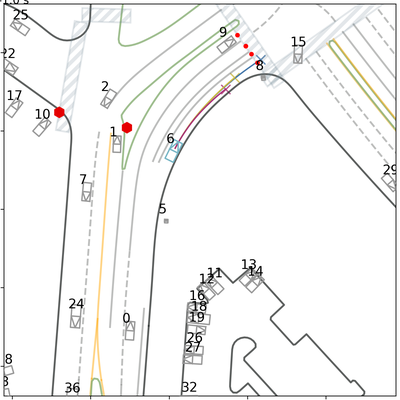

In [ ]:
results, scenario, agents_interested, batch = get_all(control_list_right, val_dataset, i, size=size)
plot_batch_all_x_with_style(
        scenario = scenario,
        agents_interested = agents_interested,
        x_ts = results, 
        style_dict = style_dict, 
        control_list = control_list_right,
        plot_freq = 1,
        dx=50,
        )